RuntimeError: This event loop is already running

call


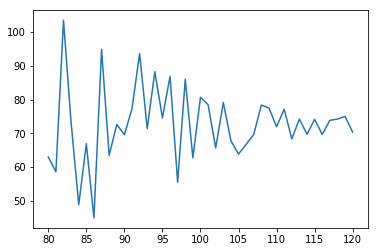

put


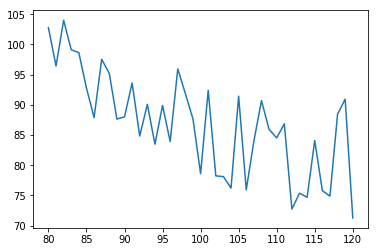

call


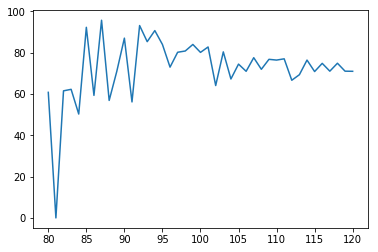

put


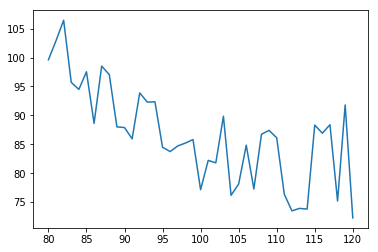

call


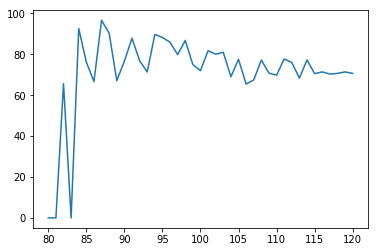

put


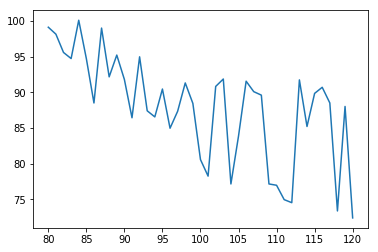

call


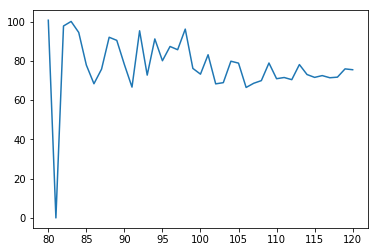

put


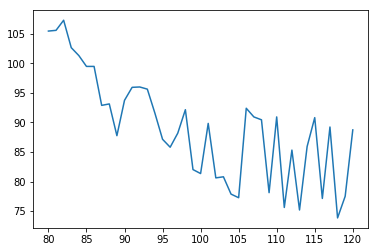

call


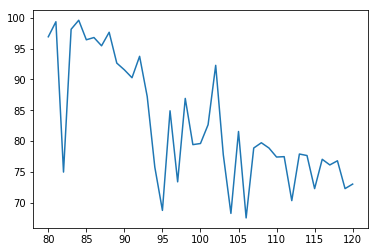

put


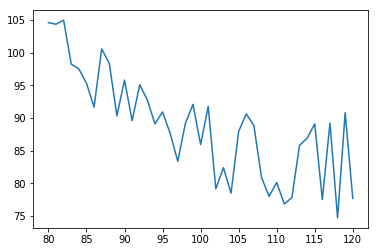

call


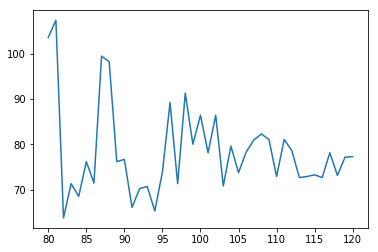

put


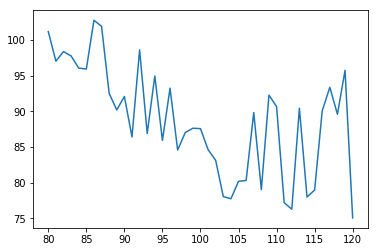

call


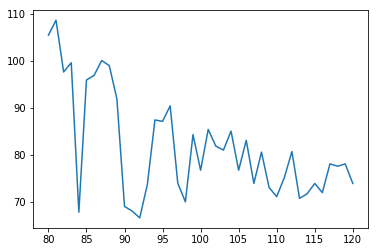

put


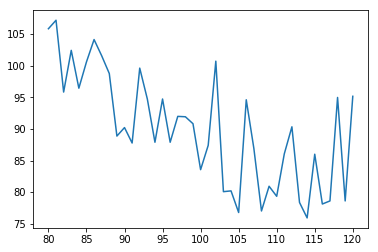

call


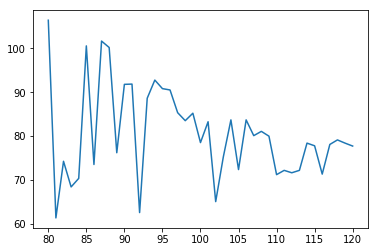

put


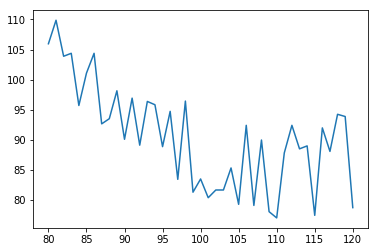

call


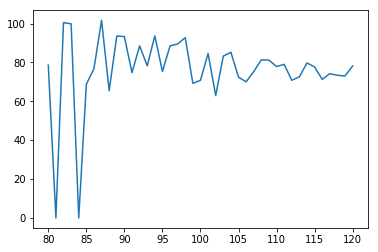

put


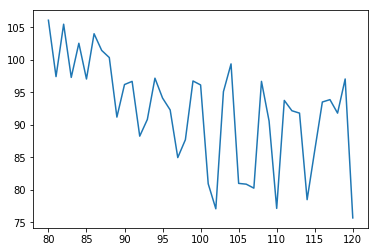

call


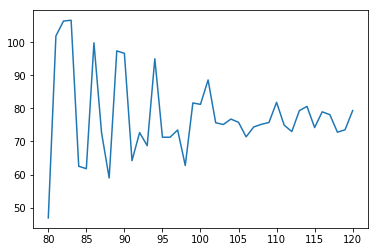

put


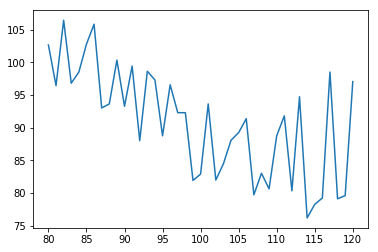

call


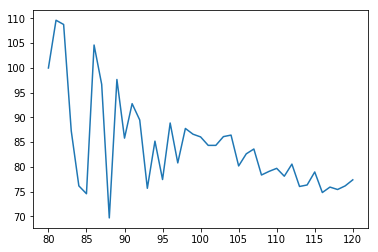

put


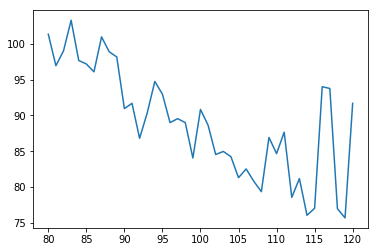

call


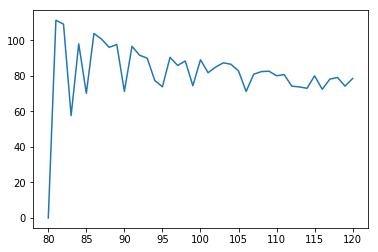

put


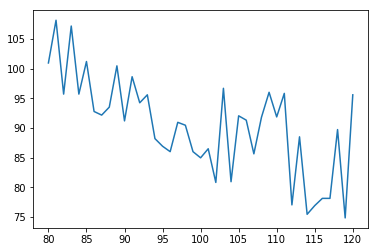

call


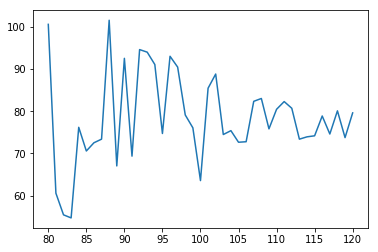

put


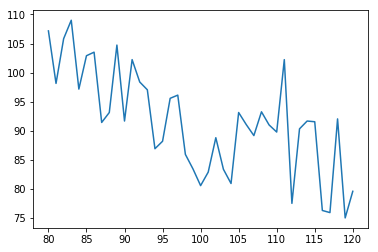

call


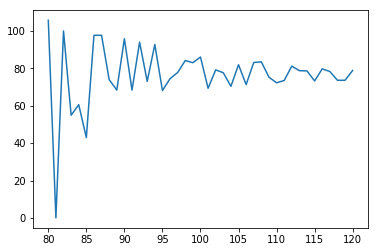

put


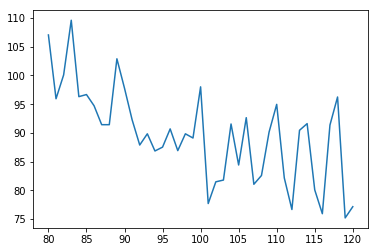

call


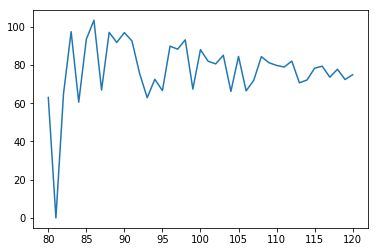

put


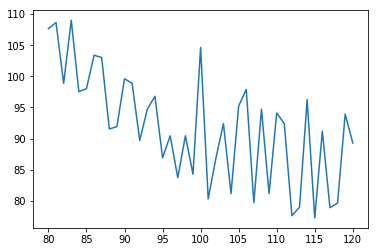

call


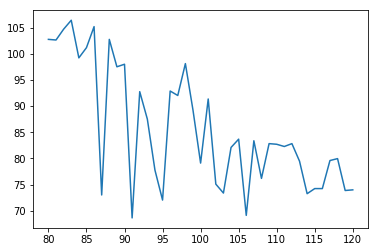

put


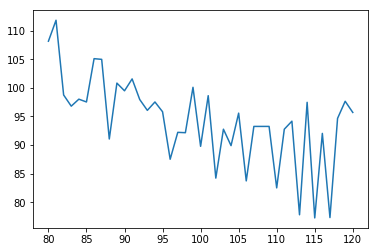

call


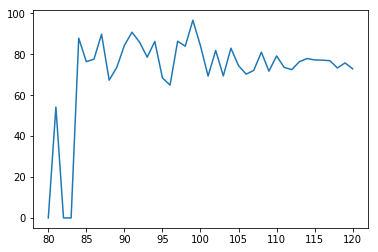

put


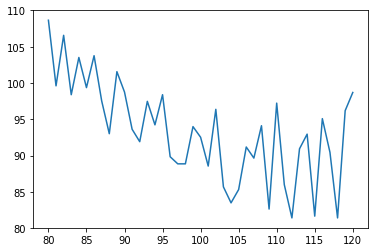

call


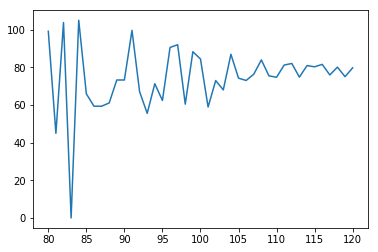

put


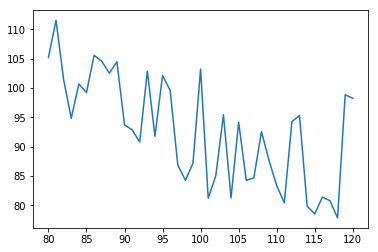

call


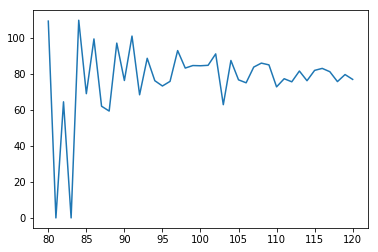

put


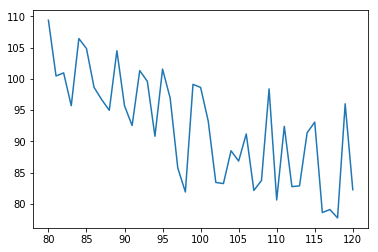

In [2]:
import tradersbot as tt
import time
import mibian
import scipy
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import py_vollib.black_scholes.implied_volatility as iv


t = tt.TradersBot(host='127.0.0.1', id='trader0', password='trader0')
# Keeps track of prices
SECURITIES = {}
UNDERLYINGS = {}
MARKET_STATES = {}
TRADER_STATE = {}

end_time = None

count = 0

SPREAD = 0.05
spot = 100
puts = {}
calls = {}
puts_ivs = {}
calls_ivs = {}
put_greeks = {}
call_greeks = {}
start = time.time()

threshold = 0

order_id = []
info = []

history = {} # ticker : [isBuy, quantity, price]

# class VolCurve():
#
#     def __init__(self, sec_state):
#         self.name = sec_state['ticker']
#         self.bids = sec_state['bids']
#         self.asks = sec_state['asks']
#         self.price = sec_state['price']
#         self.time = sec_state['time']
#         self.volcurve = None
#
#
#     def calc_volcurve(self):
#         volcurve = None
#
#         self.volcurve = volcurve
#



def ack_register(msg, order):
    global SECURITIES
    security_dict = msg['case_meta']['securities']
    underlying_dict = msg['case_meta']['underlyings']
    market_states = msg['market_states']
    trader_state = msg['trader_state']

    for security in security_dict.keys():
        if not(security_dict[security]['tradeable']):
            continue
        SECURITIES[security] = security_dict[security]['starting_price']

    for underlying in underlying_dict.keys():
        UNDERLYINGS[underlying] = underlying_dict[underlying]

    for mkt_state in market_states.keys():
        MARKET_STATES[mkt_state] = market_states[mkt_state]
    TRADER_STATE = trader_state

#     print(SECURITIES)
#     print(UNDERLYINGS)
#     print(MARKET_STATES)
#     print(TRADER_STATE)
#     print()


def market_update(msg, order):
    global count
    global spot
    global puts
    global calls

    count += 1

    option_state = msg['market_state']
    option_ticker = option_state['ticker']
    option_bids = option_state['bids']
    option_asks = option_state['asks']
    option_price = (option_state['last_price'])
    option_time = option_state['time']

    option_type = option_ticker[-1]
    option_strike = option_ticker[1:-1]
    #print(option_ticker, option_time)

    if option_type == 'P':
        puts[option_strike] = option_price
    elif option_type == 'C':
        calls[option_strike] = option_price
    elif option_ticker == 'TMXFUT':
        spot = option_price
    else:
        print('unexpected security state')

    t = 0
    if (len(calls)+len(puts))!=82:
        t=1
    else:
        calls_calc = calls.copy()
        puts_calc = puts.copy()
        implied_vols(calls_calc, puts_calc)
        vol_smile(calls_calc, puts_calc)
        calls = {}
        puts = {}

    # do we still want to keep all the old puts/calls?


    #smileTrade(order)

    #cancelOrders(order)

    # mid = (max(float(option_bids.keys()[-1])) + min(float(option_asks.keys()[0])) / 2
    # if abs(mid - min(msg['market_state']['asks'], key=int)) * 1.0 / mid >= SPREAD:
    #     makeMarket(ticker, val, direction, mid, order)


def implied_vols(calls_calc, puts_calc):
    global calls_ivs
    global puts_ivs
    global calls
    global puts
    global call_greeks
    global put_greeks
    time_left = 7.5*60 - (time.time() - start)
    days_left = 30/450*time_left

    for call in calls_calc:
        #BS([underlyingPrice, strikePrice, interestRate, daysToExpiration], volatility=x, callPrice=y, putPrice=z)
        val = mibian.BS([spot, int(call), 0, time_left/15.0], callPrice=calls[call])
        #iv_call = iv.implied_volatility(calls[call], spot, float(call), days_left/365, 0, 'c')
        #print(val.impliedVolatility)
        iv_call = val.impliedVolatility
        calls_ivs[call] = round(iv_call, 5)
        #call_greeks[call] = (bs.impliedVolatility, bs.callDelta, bs.vega, bs.gamma)

    for put in puts_calc:
        val= mibian.BS([spot, int(put), 0, time_left / 15.0], putPrice=puts[put])
        #iv_put = iv.implied_volatility(puts[put], spot, float(put), days_left/365, 0, 'p')
        #print(val.impliedVolatility)
        iv_put = val.impliedVolatility
        puts_ivs[put] = round(iv_put, 5)
        #put_greeks[put] = (bs.impliedVolatility, bs.putDelta, bs.vega, bs.gamma)



def vol_smile(calls_calc, puts_calc):
    global puts_ivs
    global calls_ivs
    global spot
    callstrikes = []
    callstrikes_ivs = []
    print('call')
    for i in range(80,121):
        callstrikes.append(i)
        callstrikes_ivs.append(calls_ivs[str(i)])
    plt.plot(callstrikes, callstrikes_ivs)
    plt.show()
    #plt.show()
    #3print(callstrikes_ivs, spot)
    print('put')
    putstrikes = []
    putstrikes_ivs = []
    for i in range(80,121):
        putstrikes.append(i)
        putstrikes_ivs.append(puts_ivs[str(i)])
    plt.plot(putstrikes, putstrikes_ivs)
    plt.show()


#
# def makeMarket(ticker, val, direction, mid, order):
#     if direction == 'P':
#         delta = put_greeks[val][0]
#     else:
#         delta = call_greeks[val][0]
#     if delta > 0:
#         # make a put offer if delta favors calls
#         makeTrade(ticker[:-1] + 'P', True, 5, int(mid * 0.95), order)
#     else:
#         makeTrade(ticker[:-1] + 'C', True, 5, int(mid * 1.05), order)
#
#
# def cancelOrders(order):
#         global order_id
#         global info
#         print('canceling')
#         print(len(order_id))
#         if (len(order_id) == 0):
#                 print('zeo')
#                 return
#         for i in range(len(order_id)):
#                 print('can')
#                 order.addCancel(info[i], order_id[i])
#                 print('done')
#         order_id = []
#         info = []
#
#
# def ack_modify_order(msg, order):
#     global threshold
#     if 'orders' in msg:
#             for k in msg['orders']:
#                     order_id.append(k['order_id'])
#                     info.append(k['ticker'])
#                     threshold -= 1
#
#
# def trader_update(msg, order):
#     status = msg['trader_state']['positions']
#     delta, vega = calcNetDeltaVega(status)
#     for ticker in calls:
#         if call_greeks[ticker][1] <= abs(delta):
#             if delta > 0:
#                 makeTrade('T' + ticker + 'C', False, abs(delta/call_greeks[ticker][1]), 1.05 * calls[ticker], order)
#             else:
#                 makeTrade('T' + ticker + 'C', True, abs(delta/call_greeks[ticker][1]), 1.05 * calls[ticker], order)
#             break
#
#     '''
#     get net delta and vega from our positions
#
#     hedge delta and vega
#
#     find stocks to buy/sell such that delta/vega approach 0
#
#     delta of 100, stock has delta of 1
#
#     try to just do delta
#
#
#     '''
#
#
# def calcNetDeltaVega(positions):
#     net_delta = 0
#     net_vega = 0
#     print(positions)
#     print(put_greeks)
#     print(call_greeks)
#     for ticker in positions:
#         if ticker[-1] == 'P' and ticker[1:-1] in put_greeks and put_greeks[ticker[1:-1]][1] != None:
#             net_delta += put_greeks[ticker[1:-1]][1]
#             net_vega += put_greeks[ticker[1:-1]][2]
#         elif ticker[-1] == 'C' and ticker[1:-1] in call_greeks and call_greeks[ticker[1:-1]][1] != None:
#             print(call_greeks[ticker[1:-1]])
#             net_delta += call_greeks[ticker[1:-1]][1]
#             net_vega += call_greeks[ticker[1:-1]][2]
#     return net_delta, net_vega
#
#
def smileTrade(order):
    index = 80
    difference = 1000
    call_ll = sorted(list(call_greeks))
    put_ll = sorted(list(put_greeks))
    for i in range(len(call_ll)):
        diff = abs(spot - call_greeks[call_ll[i]][0])
        if diff < difference:
                index = i
                difference = diff

    print(call_greeks)

    for i in range(index, len(call_ll) - 1):
        print(i)
        #if the volatility
        print(call_greeks[call_ll[i]][0])
        if ( call_greeks[call_ll[i+1]][0] < call_greeks[call_ll[i]][0]):
            ticker = "T"+str(call_ll[i+1])+"C"

            print(ticker)
            print (calls[call_ll[i+1]]*1.05)
            makeTrade(ticker, True, 1, calls[call_ll[i+1]]*1.05, order)

    index = 80
    difference = 1000
    print(put_ll)
    for i in range(len(put_ll)):
        print(put_greeks[put_ll[i]])
        diff = abs(spot - put_greeks[put_ll[i]][0])
        if diff < difference:
                index = i
                difference = diff
    for i in range(min(len(put_ll) - 1, index), 1, -1):
        print(i)
        #if the volatility
        print(put_greeks[put_ll[i]][0])
        if (put_greeks[put_ll[i-1]][0] > put_greeks[put_ll[i]][0]):
            ticker = "T"+str(put_ll[i-1])+"P"
            print(ticker)
            print (puts[put_ll[i-1]]*0.95)
            makeTrade(ticker, True, 1, puts[put_ll[i-1]]*0.95, order)

#
# def makeTrade(ticker, isBuy, quantity, price, order):
#     global threshold
#     if threshold < 10:
#         if ticker not in history:
#                 history[ticker] = []
#         history[ticker].append([isBuy, quantity, price])
#         order.addTrade(ticker, isBuy, quantity, price)
#         threshold += 1
#
#
# def trade(msg, order):
#     print('msg', msg)
#
# def news(msg, order):
#     print('msg', msg)
#
#
t.onMarketUpdate = market_update
# t.onTrade = trade
# t.onAckModifyOrders = ack_modify_order
# t.onTraderUpdate = trader_update
t.onAckRegister = ack_register
# t.onNews = news
t.run()
